# Calculate metrics

To illustrate the toolkit's ability to compare various synthesizer, let's calculate quality metrics for 4 distinct single-table datasets and 17 synthetic versions each, that were published as part of [Platzer and Reutterer (2021)](https://www.frontiersin.org/journals/big-data/articles/10.3389/fdata.2021.679939/full).

Note, that each generated report will take several minutes, thus total computation can take several hours.

In [1]:
import pandas as pd
from mostlyai import qa

path = "https://github.com/mostly-ai/paper-fidelity-accuracy/raw/refs/heads/main/data/"
datasets = ["adult", "bank-marketing", "credit-default", "online-shoppers"]
synthesizers = [
    "mostly",
    "mostly_e1",
    "mostly_e2",
    "mostly_e4",
    "mostly_e8",
    "flip10",
    "flip20",
    "flip30",
    "flip40",
    "flip50",
    "flip60",
    "flip70",
    "flip80",
    "flip90",
    "gretel",
    "synthpop",
    "ctgan",
]

# ENABLE HERE FOR REPRODUCING BENCHMARK RESULTS
if False:
    rows = []
    for dataset in datasets:
        tgt = pd.read_csv(path + f"{dataset}_trn.csv.gz")
        hol = pd.read_csv(path + f"{dataset}_val.csv.gz")
        for synthesizer in synthesizers:
            try:
                syn = pd.read_csv(path + f"{dataset}_{synthesizer}.csv.gz")
                print(dataset, synthesizer, tgt.shape, hol.shape, syn.shape)
                report_path, metrics = qa.report(
                    syn_tgt_data=syn,
                    trn_tgt_data=tgt,
                    hol_tgt_data=hol,
                )
                row = pd.json_normalize(metrics, sep="_")
                row.insert(0, "dataset", dataset)
                row.insert(1, "synthesizer", synthesizer)
                rows += [row]
            except Exception as e:
                print(e)

    df = pd.DataFrame(rows)
    df.to_csv("benchmark-examples.csv", index=False)

## Compare metrics

Calculate ratios with respect to holdout (north star), and visualize as a privacy-utility trade-off curve.

In [2]:
import pandas as pd

# load results
df = pd.read_csv("benchmark-examples.csv")
# calculate ratios with respect to Holdout
df["acc_ratio"] = df["accuracy_overall"] / df["accuracy_overall_max"]
df["sim_ratio"] = (
    df["similarity_cosine_similarity_training_synthetic"] / df["similarity_cosine_similarity_training_holdout"]
)
df["dcr_ratio"] = df["distances_dcr_training"] / df["distances_dcr_holdout"]
df

,dataset,synthesizer,accuracy_overall,accuracy_overall_max,accuracy_univariate,accuracy_univariate_max,accuracy_bivariate,accuracy_bivariate_max,distances_dcr_training,distances_dcr_holdout,distances_dcr_share,similarity_cosine_similarity_training_synthetic,similarity_cosine_similarity_training_holdout,similarity_discriminator_auc_training_synthetic,similarity_discriminator_auc_training_holdout,acc_ratio,sim_ratio,dcr_ratio
0,adult,mostly,0.984,0.99,0.990,0.994,0.979,0.985,0.201,0.202,0.502109,0.999972,0.999986,0.523,0.506,0.993939,0.999986,0.995050
1,adult,mostly_e1,0.958,0.99,0.975,0.994,0.940,0.985,0.225,0.224,0.502518,0.999794,0.999986,0.656,0.505,0.967677,0.999808,1.004464
2,adult,mostly_e2,0.966,0.99,0.979,0.994,0.953,0.985,0.213,0.212,0.496540,0.999845,0.999986,0.577,0.502,0.975758,0.999859,1.004717
3,adult,mostly_e4,0.974,0.99,0.983,0.994,0.964,0.985,0.207,0.206,0.495311,0.999927,0.999986,0.551,0.504,0.983838,0.999941,1.004854
4,adult,mostly_e8,0.972,0.99,0.981,0.994,0.964,0.985,0.205,0.205,0.499242,0.999874,0.999986,0.554,0.503,0.981818,0.999888,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,online-shoppers,flip80,0.959,0.98,0.996,0.989,0.922,0.972,0.165,0.168,0.518573,0.999820,0.999985,0.644,0.509,0.978571,0.999835,0.982143
63,online-shoppers,flip90,0.958,0.98,0.996,0.989,0.920,0.972,0.167,0.169,0.513706,0.999804,0.999985,0.656,0.502,0.977551,0.999819,0.988166
64,online-shoppers,gretel,0.794,0.98,0.853,0.989,0.734,0.972,0.160,0.163,0.522303,0.999467,0.999985,0.911,0.503,0.810204,0.999482,0.981595
65,online-shoppers,synthpop,0.986,0.98,0.995,0.989,0.978,0.972,0.145,0.154,0.547283,0.999995,0.999985,0.509,0.505,1.006122,1.000010,0.941558


In [3]:
import matplotlib.pyplot as plt


def plot_dataset(df, dataset):
    # Define the color mapping for each synthesizer
    color_mapping = {
        "mostly": "blue",
        "mostly_e1": "#bdd7e7",
        "mostly_e2": "#6baed6",
        "mostly_e4": "#3182bd",
        "mostly_e8": "#215b85",
        "flip10": "#810f7c",
        "flip20": "#810f7c",
        "flip30": "#810f7c",
        "flip40": "#810f7c",
        "flip50": "#810f7c",
        "flip60": "#810f7c",
        "flip70": "#810f7c",
        "flip80": "#810f7c",
        "flip90": "#810f7c",
        "synthpop": "red",
        "gretel": "orange",
        "ctgan": "green",
    }

    def scatter_plot(ax, x, y, x_label, y_label):
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.grid(True)
        for _, row in df.iterrows():
            ax.scatter(row[x], row[y], color=color_mapping[row["synthesizer"]], s=100, label=row["synthesizer"])
        ax.axhline(y=1, color="black", linestyle="--")
        ax.axvline(x=1, color="black", linestyle="--")
        ax.scatter(1, 1, color="black", s=100, edgecolor="black", zorder=5)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].set_title(f"{dataset} - Accuracy vs Distances")
    scatter_plot(axes[0], "acc_ratio", "dcr_ratio", "Accuracy Ratio (acc/acc_max)", "Distances Ratio (dcr_trn/dcr_hol)")

    axes[1].set_title(f"{dataset} - Similarity vs Distances")
    scatter_plot(
        axes[1],
        "sim_ratio",
        "dcr_ratio",
        "Similarity Ratio (sim_trn_syn/sim_trn_hol)",
        "Distances Ratio (dcr_trn/dcr_hol)",
    )

    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), title="Synthesizer", bbox_to_anchor=(0.995, 0.98), loc="upper left")

    plt.tight_layout()
    # plt.savefig('fig_adult.png')

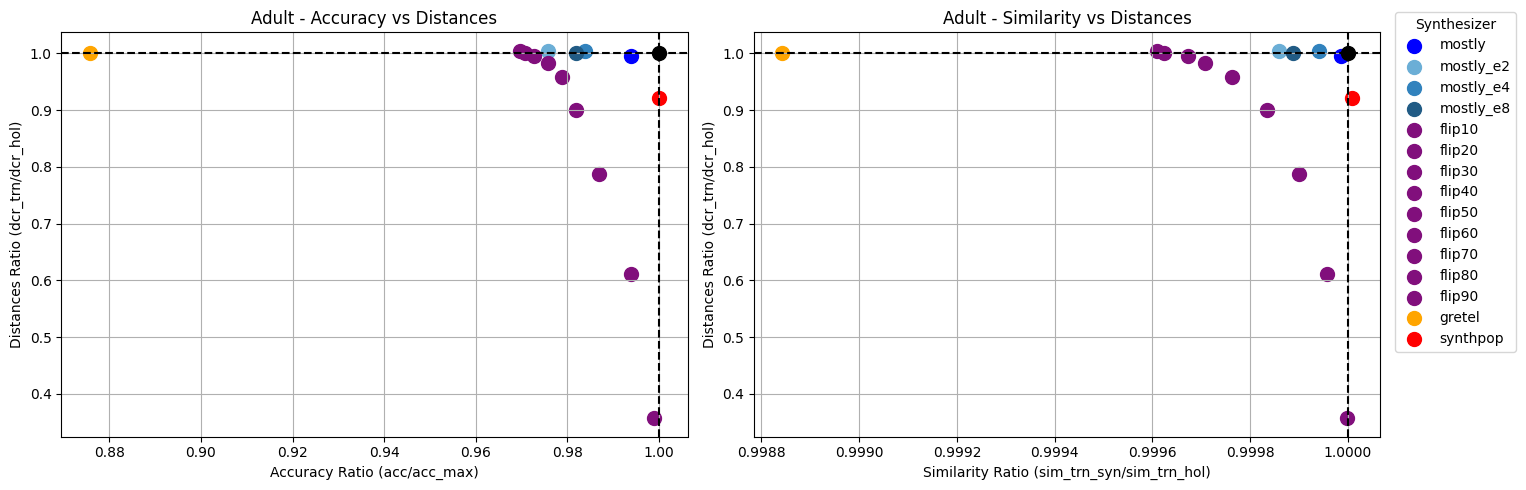

In [4]:
plot_dataset(df.loc[(df.dataset == "adult") & ~df.synthesizer.isin(["ctgan", "mostly_e1"])], "Adult")

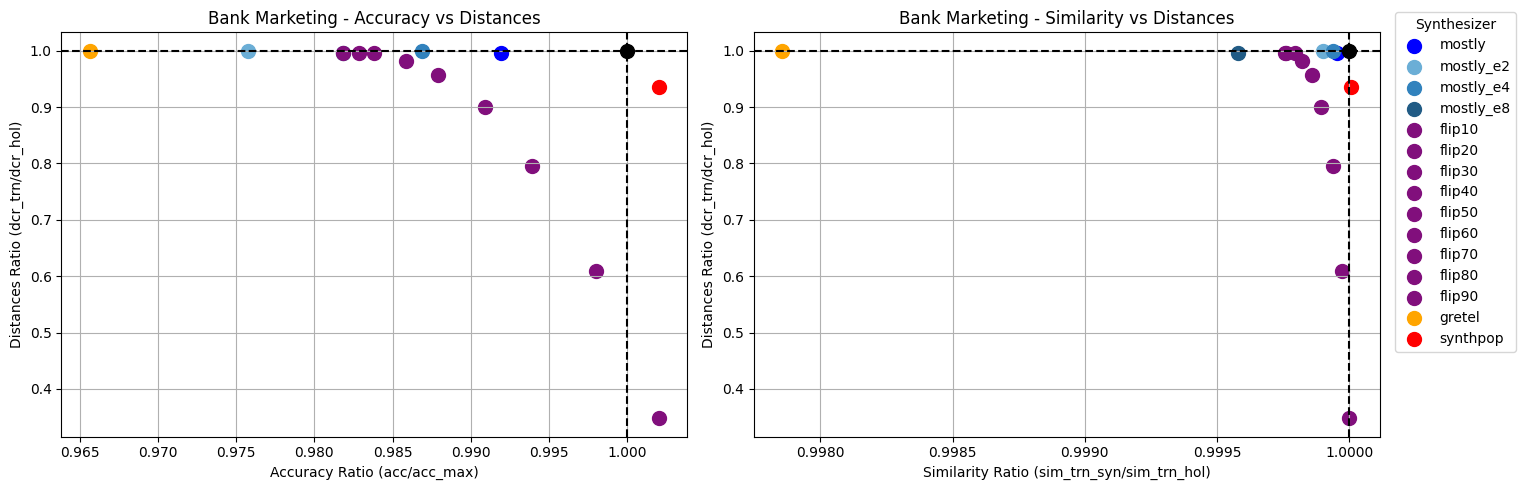

In [5]:
plot_dataset(df.loc[(df.dataset == "bank-marketing") & ~df.synthesizer.isin(["ctgan", "mostly_e1"])], "Bank Marketing")

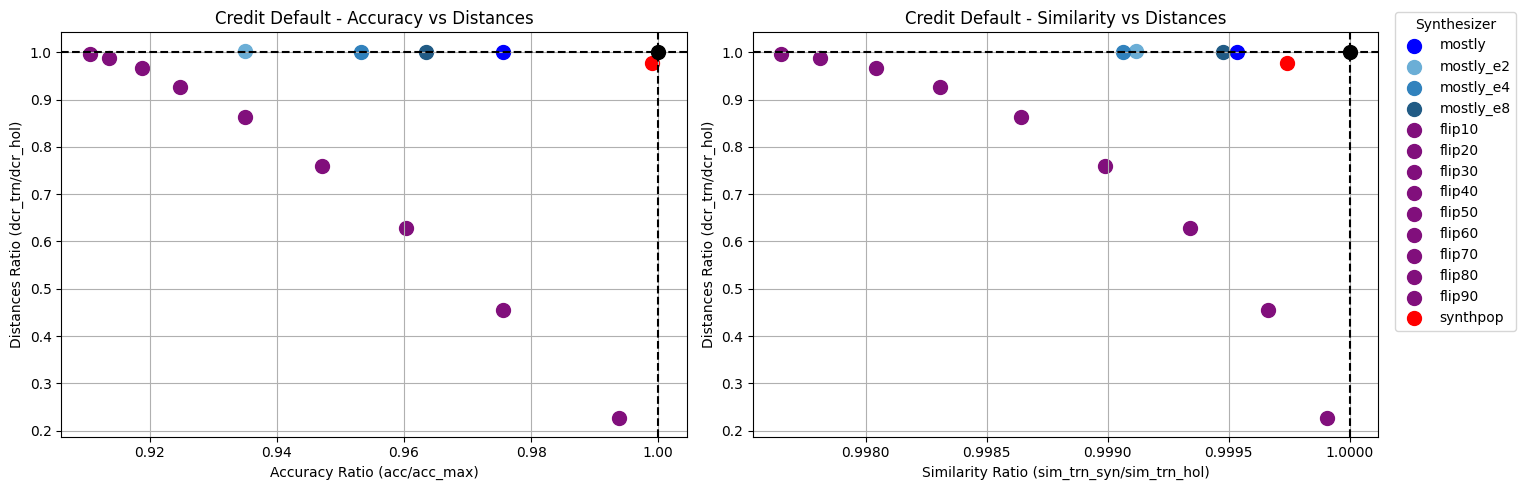

In [6]:
plot_dataset(df.loc[(df.dataset == "credit-default") & ~df.synthesizer.isin(["ctgan", "mostly_e1"])], "Credit Default")

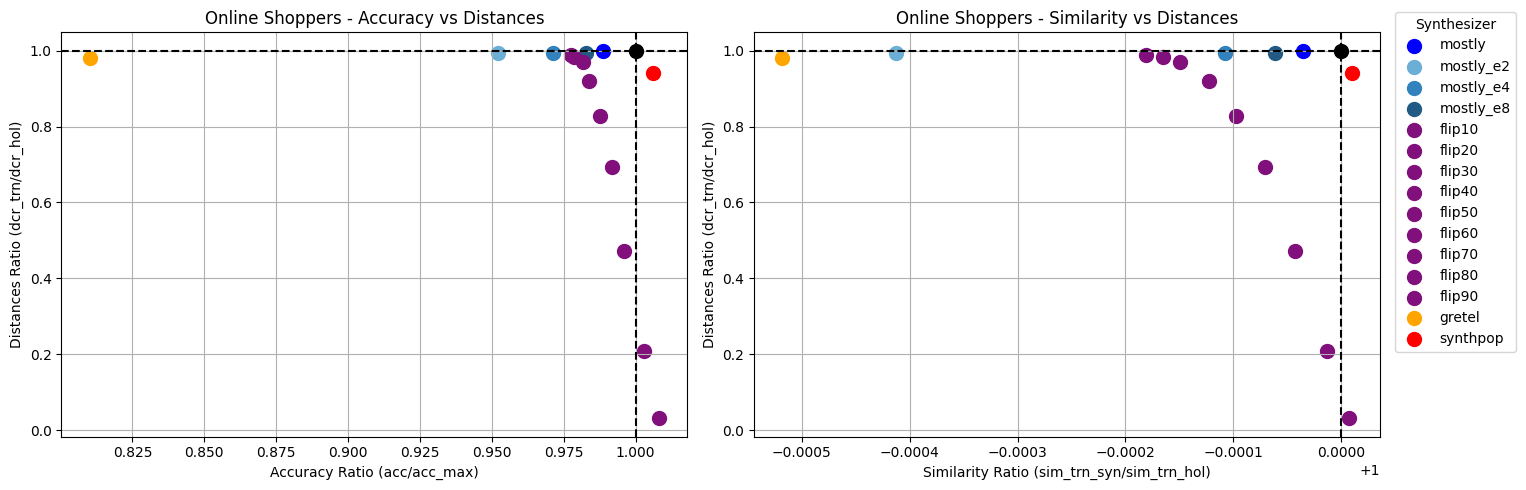

In [7]:
plot_dataset(
    df.loc[(df.dataset == "online-shoppers") & ~df.synthesizer.isin(["ctgan", "mostly_e1"])], "Online Shoppers"
)